In [1]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt


### Read the image files

We first read the image we want to align and the corresponding reference (template) image 

In [2]:
# Read the image files. 
img1_color= cv2.imread('images/align.png') # Image to be aligned. 
img2_color = cv2.imread('images/ref.png') # Reference image. 


In [3]:

# Convert to grayscale. 
img1 = cv2.cvtColor(img1_color, cv2.COLOR_BGR2GRAY) 
img2 = cv2.cvtColor(img2_color, cv2.COLOR_BGR2GRAY) 
height, width = img2.shape 

### Detect Features

Even though only 4 features are enough to define the homography, we still control the number of features using the max_features parameter

In [4]:
# Create ORB detector with 5000 features. 
max_features = 5000
sift = cv2.xfeatures2d.SIFT_create()

# Find keypoints and descriptors. 
# The first arg is the image, second arg is the mask 
# (which is not reqiured in this case). 
kp1, d1 = sift.detectAndCompute(img1, None) 
kp2, d2 = sift.detectAndCompute(img2, None) 

### Match features

In [5]:
# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
#search_params = dict(checks=500)   # or pass empty dictionary



flann = cv2.FlannBasedMatcher(index_params,search_params)

matches = flann.knnMatch(d1,d2,k=2)

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]

# ratio test as per Lowe's paper
lowe_ratio = 0.75
good = []
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]
        good.append(m)

draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = 0)

imMatches = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)
cv2.imwrite("matches_sift_flann.jpg", imMatches)



True

In [6]:
print (np.array(matches).shape)

(1305, 2)


Notice, we have many incorrect matches and thefore we will need to use a robust method to calculate homography in the next step.

### Find the homography

In [7]:
# Extract location of good matches
    
p1= np.float32(
    [kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)    
    
p2 = np.float32(
    [kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)  



    
# Find the homography matrix. 
homography, mask = cv2.findHomography(p1, p2, cv2.LMEDS, 5.0) 

### Warping image

In [8]:
# Use this matrix to transform the 
# colored image wrt the reference image. 
transformed_img = cv2.warpPerspective(img1_color, 
					homography, (width, height)) 

# Save the output. 
cv2.imwrite('output_sift_flann.jpg', transformed_img)

print("Estimated homography : \n",  homography)
  

Estimated homography : 
 [[ 1.37599339e+00  1.07361806e-01 -6.62651236e+02]
 [-2.18061377e-01  1.64095736e+00 -3.23239461e+02]
 [-1.05843081e-04  7.72514300e-05  1.00000000e+00]]


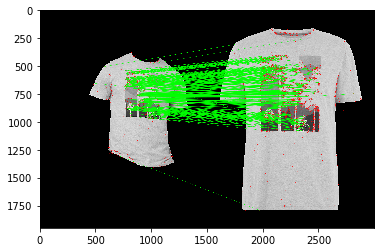

using SIFT with lowe_ratio 0.75 there are 442 good matches


In [9]:
msg1 = 'using %s with lowe_ratio %.2f' % ("SIFT-FLANN", lowe_ratio)
msg2 = 'there are %d good matches' % (len(good))

plt.imshow(imMatches),plt.show()

print (msg1 + ' '+ msg2)